# Exp 05. 집값 예측

### 라이브러리 불러오기

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import matplotlib.pyplot as plt
import seaborn as sns

## 1. 데이터 살펴보기
각 컬럼들의 의미
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

### 1) Data Load

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)

### 2) Check Data

In [3]:
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [4]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
test.tail()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
6467,21502,20150116T000000,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


## 2. 간단한 전처리 

### 1) 컬럼 확인

In [6]:
print("Train-Set Columns\n")
for i in range(len(train.columns)):
    print(i+1, train.columns[i])

Train-Set Columns

1 id
2 date
3 price
4 bedrooms
5 bathrooms
6 sqft_living
7 sqft_lot
8 floors
9 waterfront
10 view
11 condition
12 grade
13 sqft_above
14 sqft_basement
15 yr_built
16 yr_renovated
17 zipcode
18 lat
19 long
20 sqft_living15
21 sqft_lot15


In [7]:
print("Test-Set Columns\n")
for i in range(len(test.columns)):
    print(i+1, test.columns[i])

Test-Set Columns

1 id
2 date
3 bedrooms
4 bathrooms
5 sqft_living
6 sqft_lot
7 floors
8 waterfront
9 view
10 condition
11 grade
12 sqft_above
13 sqft_basement
14 yr_built
15 yr_renovated
16 zipcode
17 lat
18 long
19 sqft_living15
20 sqft_lot15


### 2) 컬럼 정리

#### 불필요한 컬럼 삭제

In [8]:
y = train['price']
del train['price']
del train['id']

for i in range(len(train.columns)):
    print(i+1, train.columns[i])

1 date
2 bedrooms
3 bathrooms
4 sqft_living
5 sqft_lot
6 floors
7 waterfront
8 view
9 condition
10 grade
11 sqft_above
12 sqft_basement
13 yr_built
14 yr_renovated
15 zipcode
16 lat
17 long
18 sqft_living15
19 sqft_lot15


In [9]:
del test['id']
for i in range(len(test.columns)):
    print(i+1, test.columns[i])

1 date
2 bedrooms
3 bathrooms
4 sqft_living
5 sqft_lot
6 floors
7 waterfront
8 view
9 condition
10 grade
11 sqft_above
12 sqft_basement
13 yr_built
14 yr_renovated
15 zipcode
16 lat
17 long
18 sqft_living15
19 sqft_lot15


#### date 컬럼 범주형 변수로 변경

In [10]:
train['date'] = train['date'].apply(lambda x : str(x[:6])).astype(int)
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [11]:
test['date'] = test['date'].apply(lambda x : str(x[:6])).astype(int)
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [12]:
# Train + Test
train_len = len(train)
test_len = len(test)
data = pd.concat((train, test), axis=0)
print(train_len, test_len)
print("Train + Test : " , len(data))
data.tail()

15035 6468
Train + Test :  21503


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6463,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
6467,201501,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  int64  
 1   bedrooms       21503 non-null  int64  
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  int64  
 4   sqft_lot       21503 non-null  int64  
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  int64  
 11  sqft_basement  21503 non-null  int64  
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  int64  
 18  sqft_lo

### 3) 결측치 확인

<AxesSubplot:>

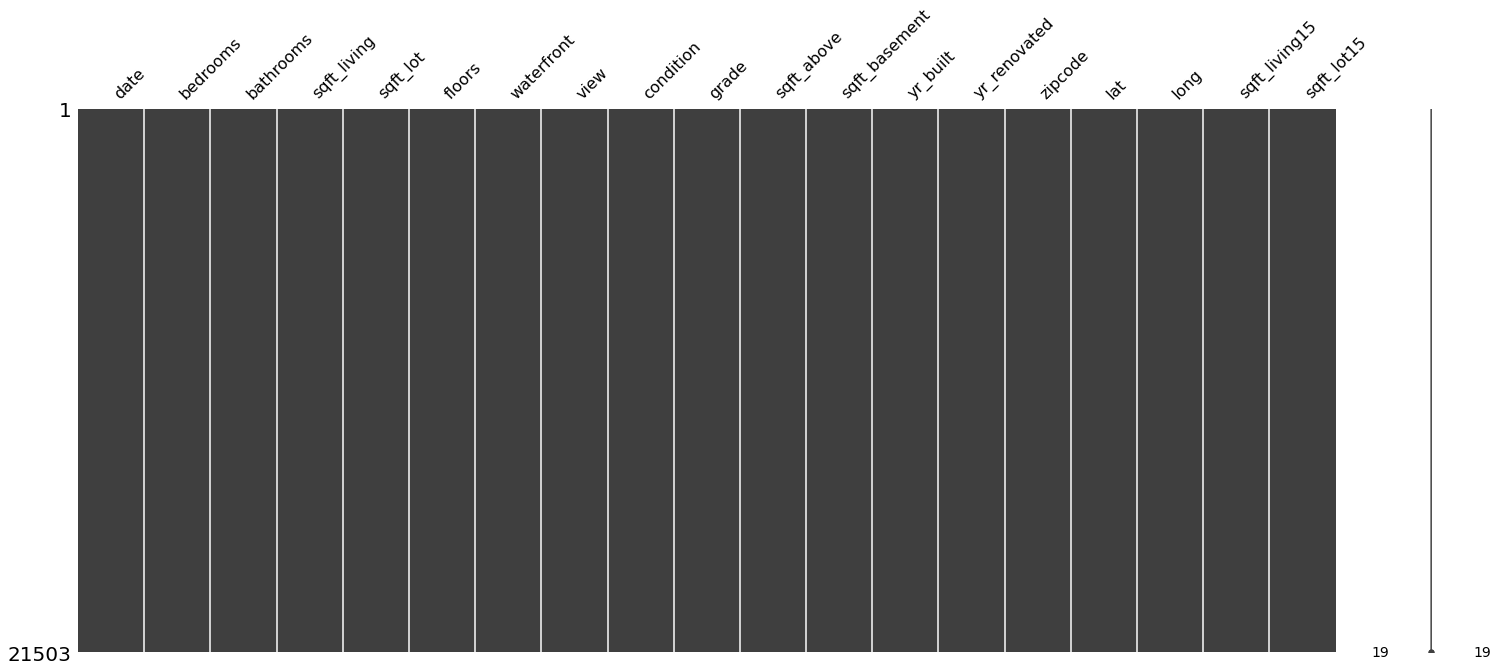

In [14]:
# 결측치 발견 시 하얀줄이 생김
msno.matrix(data)

In [15]:
# 찾지 못했을 수 있으니 재확인
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 4) 각 변수들의 분포 확인

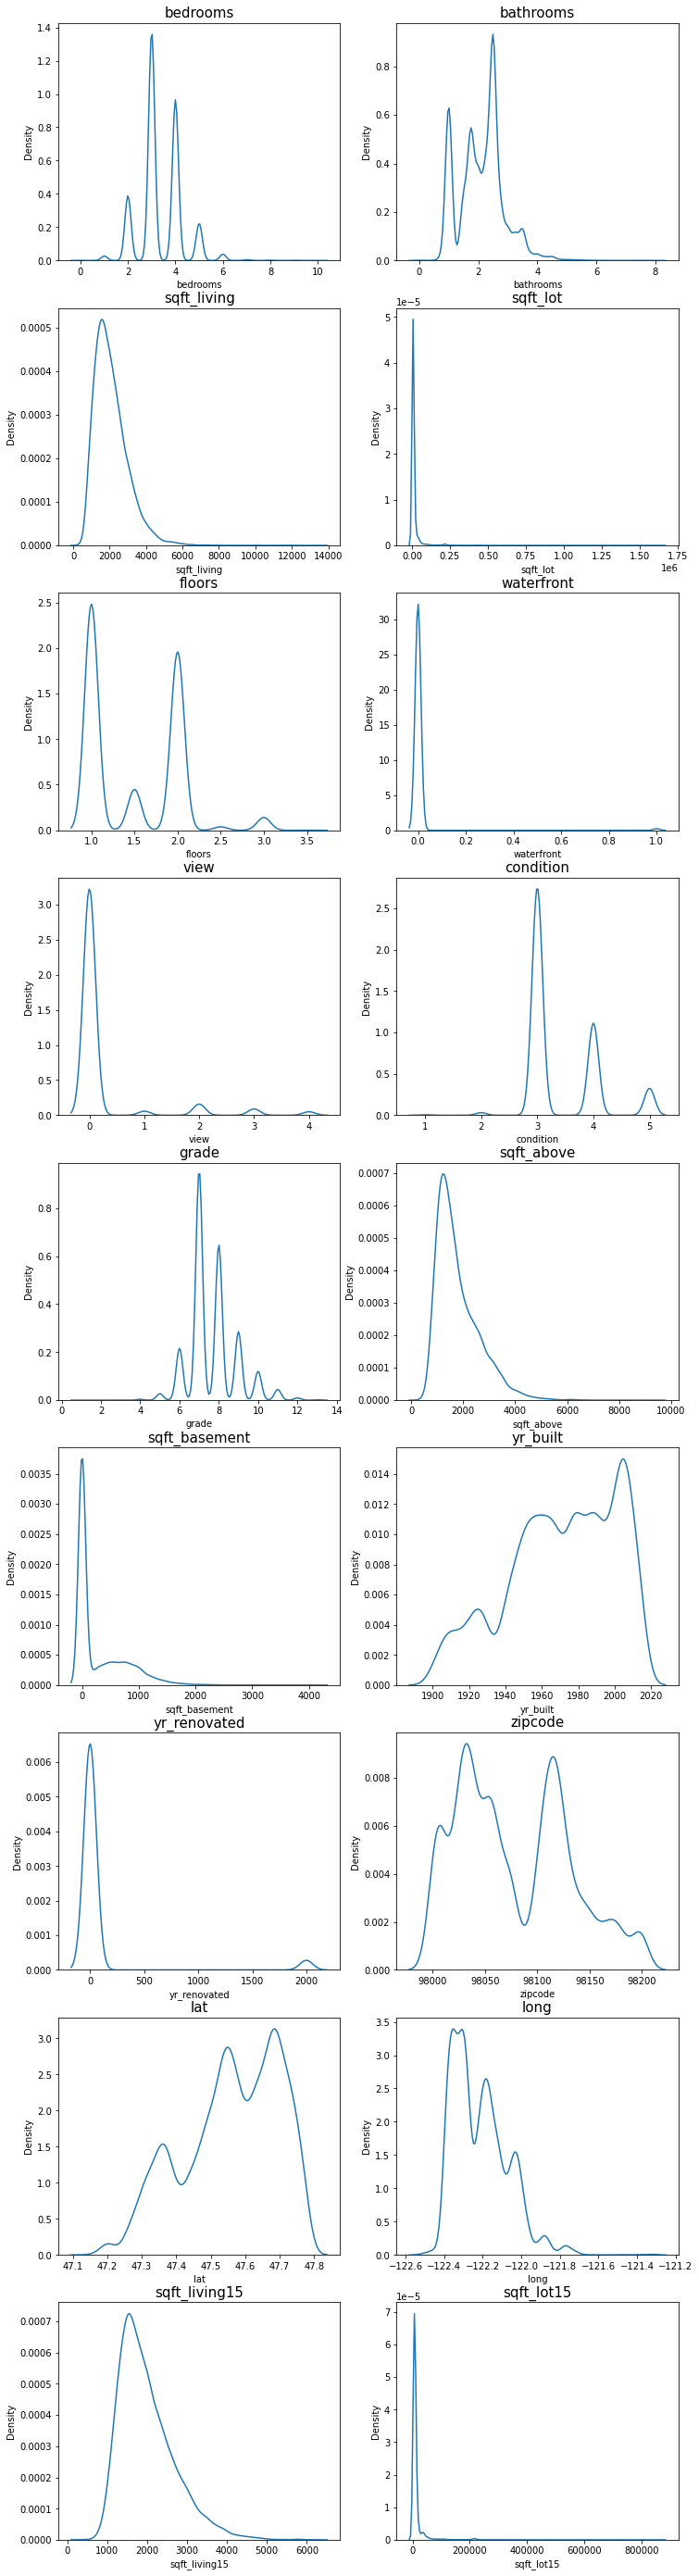

In [16]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50)) 

count = 1
columns = train.columns

for row in range(9):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [17]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

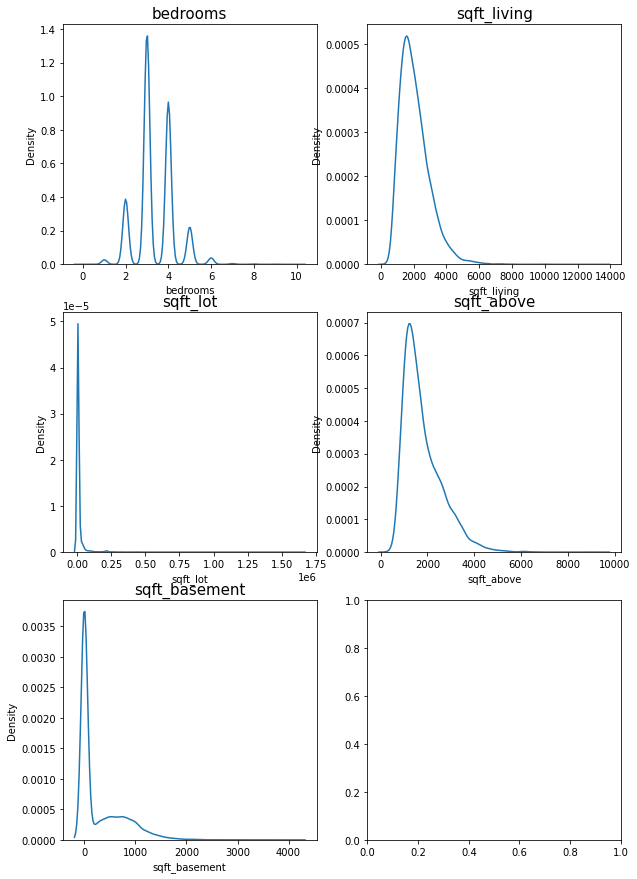

In [18]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

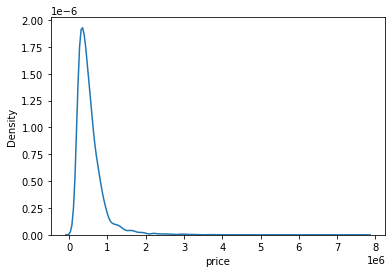

In [19]:
sns.kdeplot(y)
plt.show()

In [20]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

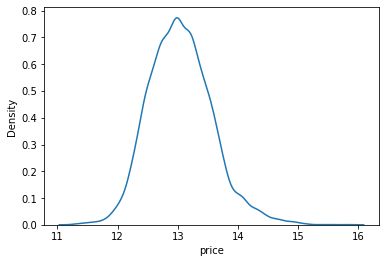

In [21]:
sns.kdeplot(y)
plt.show()

## 3. 모델링
### 1) RMSE 산출

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [23]:
iterations = 3000

In [24]:
gboost = GradientBoostingRegressor(random_state=42, n_estimators=1000)
rf = RandomForestRegressor(random_state=42, n_estimators=3000, max_depth=15, n_jobs=-1)
xgboost = xgb.XGBRegressor(random_state=42, n_estimators=1000, max_depth=5, learning_rate=0.1,n_jobs=-1)
lightgbm = lgb.LGBMRegressor(random_state=42, n_estimators=iterations, learning_rate=0.05, max_depth=7, num_leaves=50)
catboost = cb.CatBoostRegressor(random_state=42, iterations=iterations, learning_rate=0.05, task_type="GPU", verbose = 0)

# models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':rf, 'name':'RandomForest'},
#           {'model':xgboost, 'name':'XGBoost'}, {'model':lightgbm, 'name':'LightGBM'},
#           {'model':catboost, 'name':'CatBoost'}]
models = [gboost, rf, xgboost, lightgbm, catboost]

In [28]:
def get_scores(models, x, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE')
            
    return score_df

get_scores(models, train, y)

,RMSE
CatBoostRegressor,110445.922966
XGBRegressor,115044.018964
LGBMRegressor,118244.532487
GradientBoostingRegressor,119328.944209
RandomForestRegressor,166059.295346


In [32]:
get_scores(models, train, y)

,RMSE
CatBoostRegressor,110445.922966
XGBRegressor,115044.018964
LGBMRegressor,118244.532487
GradientBoostingRegressor,119328.944209
RandomForestRegressor,140694.233031


### 2) 그리드 탐색

In [25]:
from sklearn.model_selection import GridSearchCV

In [32]:
def grid_Result(model, x, y, param_grid, verbose=2, n_jobs=-1):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', 
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    grid_model.fit(x, y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score

    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [42]:
param_grid = {
    'n_estimators': [1000, 2000, 3000],
    'max_depth': [5, 7, 10],
    'learning_rate':[0.1, 0.05]
}

In [38]:
model = lgb.LGBMRegressor(random_state=42)
grid_Result(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
12,0.05,7,1000,-0.025925,0.161011
15,0.05,10,1000,-0.025930,0.161028
9,0.05,5,1000,-0.026226,0.161946
13,0.05,7,2000,-0.026371,0.162392
16,0.05,10,2000,-0.026450,0.162633
10,0.05,5,2000,-0.026485,0.162743
6,0.10,10,1000,-0.026739,0.163521
17,0.05,10,3000,-0.026783,0.163654
14,0.05,7,3000,-0.026790,0.163676
3,0.10,7,1000,-0.026810,0.163736


In [44]:
model = cb.CatBoostRegressor(random_state=42, verbose=0)
grid_Result(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ..learning_rate=0.1, max_depth=5, n_estimators=1000; total time=   8.0s
[CV] END ..learning_rate=0.1, max_depth=5, n_estimators=1000; total time=   8.1s
[CV] END ..learning_rate=0.1, max_depth=5, n_estimators=2000; total time=  16.8s
[CV] END ..learning_rate=0.1, max_depth=5, n_estimators=3000; total time=  25.4s
[CV] END ..learning_rate=0.1, max_depth=5, n_estimators=3000; total time=  24.6s
[CV] END ..learning_rate=0.1, max_depth=7, n_estimators=1000; total time=  16.6s
[CV] END ..learning_rate=0.1, max_depth=7, n_estimators=1000; total time=  16.5s
[CV] END ..learning_rate=0.1, max_depth=7, n_estimators=2000; total time=  33.1s
[CV] END ..learning_rate=0.1, max_depth=7, n_estimators=3000; total time=  49.2s
[CV] END ..learning_rate=0.1, max_depth=7, n_estimators=3000; total time=  51.7s
[CV] END .learning_rate=0.1, max_depth=10, n_estimators=1000; total time= 1.2min
[CV] END .learning_rate=0.1, max_depth=10, n_est

,learning_rate,max_depth,n_estimators,score,RMSLE
10,0.05,5,2000,-0.024940,0.157926
11,0.05,5,3000,-0.024942,0.157929
13,0.05,7,2000,-0.024967,0.158010
0,0.10,5,1000,-0.024982,0.158055
12,0.05,7,1000,-0.025031,0.158212
14,0.05,7,3000,-0.025110,0.158460
1,0.10,5,2000,-0.025123,0.158501
3,0.10,7,1000,-0.025342,0.159191
2,0.10,5,3000,-0.025418,0.159430
9,0.05,5,1000,-0.025493,0.159665


In [45]:
model = cb.CatBoostRegressor(random_state=42, max_depth=5, iterations=2000, learning_rate=0.05, task_type="GPU", verbose = 0)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.1707616 , 13.01723827, 14.11124568, ..., 13.00155501,
       12.65638772, 12.95719748])

In [46]:
prediction = np.expm1(prediction)
prediction

array([ 524793.27227055,  450104.94798296, 1344113.08415808, ...,
        443100.88476019,  313760.27945554,  423875.52645865])

[CV] END .learning_rate=0.05, max_depth=5, n_estimators=3000; total time=  24.2s
[CV] END .learning_rate=0.05, max_depth=5, n_estimators=3000; total time=  25.3s
[CV] END .learning_rate=0.05, max_depth=5, n_estimators=3000; total time=  25.2s
[CV] END .learning_rate=0.05, max_depth=7, n_estimators=1000; total time=  16.7s
[CV] END .learning_rate=0.05, max_depth=7, n_estimators=1000; total time=  16.2s
[CV] END .learning_rate=0.05, max_depth=7, n_estimators=2000; total time=  31.9s
[CV] END .learning_rate=0.05, max_depth=7, n_estimators=3000; total time=  48.1s
[CV] END .learning_rate=0.05, max_depth=7, n_estimators=3000; total time=  49.5s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=1000; total time= 1.2min
[CV] END learning_rate=0.05, max_depth=10, n_estimators=1000; total time= 1.3min
[CV] END learning_rate=0.05, max_depth=10, n_estimators=2000; total time= 2.2min
[CV] END learning_rate=0.05, max_depth=10, n_estimators=3000; total time= 3.0min
[CV] END learning_rate=0.05,

## 4. Submission 제출

In [47]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

[CV] END learning_rate=0.05, max_depth=10, n_estimators=3000; total time= 1.4min


In [48]:
save_submission(model, train, y, test, 'catboost', rmsle='0.157926')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_catboost_RMSLE_0.157926.csv saved!


## 5. 회고

- LMS에서 나온 기본 모델이 아닌 CatBoost라는 모델을 사용해봤다.
- LGBM 이나 XGBoost보다 나은 성능을 나타낸다.
- 실제 제출시 110243.33620의 성능을 보인다.
- LMS의 평가치에는 살짝 못미치는 점수라 아쉬움이 남는다.
- 하이퍼 파라미터 수정으로는 힘들거 같고 데이터 전처리를 조금 더 신경 쓰면 평가치에 도달할 수 있을거 같다.